# Test word embeddingu

## Celem tego notebooka jest sprawdzenie wpływu warstwy embedding na działanie rekurencyjej sieci neuronowej, generującej tekst.






Tworzę obiekty dataset. Ze względu na to, iż warstwa embedding sama wykonuje kodowanie 1 z n (one-hot), dla modelu niezawierającego tej warstwy muszę ręcznie wykonać kodowanie, przez co model ten będzie używać innych obiektów dataset.

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import matplotlib.pyplot as plt

#text = open('pan-tadeusz.txt', 'r', encoding='utf-8').read()
text = open('drive/My Drive/Colab Notebooks/MickiewiczTextGeneration/pan-tadeusz.txt', 'r', encoding='utf-8').read()
vocab = sorted(set(text))
vocab_size = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

sequences = []
step = 100
for i in range(0, len(text)-seq_length, step):
    sequences.append(text_as_int[i:i+seq_length+1])

dataset = tf.data.Dataset.from_tensor_slices(sequences)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

def split_encoded_input_target(chunk):
    input_text = chunk[:-1]
    encoded = tf.one_hot(input_text, vocab_size)
    target_text = chunk[1:]
    return encoded, target_text
 
dataset_encoded = dataset.map(split_encoded_input_target)
dataset_not_encoded = dataset.map(split_input_target)

BATCH_SIZE = 32
BUFFER_SIZE = 1000

dataset_encoded = dataset_encoded.batch(BATCH_SIZE, drop_remainder=True)
dataset_not_encoded = dataset_not_encoded.batch(BATCH_SIZE, drop_remainder=True)

train_part = 0.8
DATASET_SIZE = len(sequences) // BATCH_SIZE
train_size = int(train_part * DATASET_SIZE)
test_size = int((1-train_part) * DATASET_SIZE)

train_dataset_encoded = dataset_encoded.take(train_size)
train_dataset_encoded = train_dataset_encoded.shuffle(BUFFER_SIZE)
test_dataset_encoded = dataset_encoded.skip(train_size)
test_dataset_encoded = test_dataset_encoded.shuffle(BUFFER_SIZE)

train_dataset_not_encoded = dataset_not_encoded.take(train_size)
train_dataset_not_encoded = train_dataset_not_encoded.shuffle(BUFFER_SIZE)
test_dataset_not_encoded = dataset_not_encoded.skip(train_size)
test_dataset_not_encoded = test_dataset_not_encoded.shuffle(BUFFER_SIZE)


Buduję modele o różnych wielkościach embeddingu.

In [ ]:
def build_model(vocab_size, rnn_units, batch_size, embedding, embedding_dim=64):
    if embedding:
        return tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                      batch_input_shape=[batch_size, None]), 
            tf.keras.layers.LSTM(rnn_units,
                                return_sequences=True,
                                stateful=True,
                                recurrent_initializer='glorot_uniform'),
            tf.keras.layers.Dense(vocab_size)
        ])
    else:
        return tf.keras.Sequential([
            tf.keras.layers.Input(batch_input_shape=[batch_size, None, vocab_size]),
            tf.keras.layers.LSTM(rnn_units,
                                return_sequences=True,
                                stateful=True,
                                recurrent_initializer='glorot_uniform'),
            tf.keras.layers.Dense(vocab_size)
        ])

models = [
    build_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=256,
    batch_size=BATCH_SIZE,
    embedding=True)
    for embedding_dim in [32,64,128,256]
]

model_no_embedding = build_model(
    vocab_size=vocab_size,
    rnn_units=256,
    batch_size=BATCH_SIZE,
    embedding=False)
    

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

for model in models:
    model.compile(optimizer='adam', loss=loss)
    
model_no_embedding.compile(optimizer='adam', loss=loss)
        
print("READY")

READY


Przeprowadzam trening.

In [ ]:
EPOCHS = 40

histories = []

#with tf.device('/cpu:0'):
with tf.device('/device:GPU:0'):
    for model in models :
        history = model.fit(train_dataset_not_encoded, epochs=EPOCHS, validation_data=test_dataset_not_encoded)
        histories.append(history)
        
    history = model_no_embedding.fit(train_dataset_encoded, epochs=EPOCHS, validation_data=test_dataset_encoded)
    histories.append(history)
    
    


Epoch 1/40
109/109 [==============================] - 2s 14ms/step - loss: 3.4125 - val_loss: 3.1900
Epoch 2/40
109/109 [==============================] - 1s 10ms/step - loss: 2.8502 - val_loss: 2.6563
Epoch 3/40
109/109 [==============================] - 1s 10ms/step - loss: 2.5760 - val_loss: 2.5308
Epoch 4/40
109/109 [==============================] - 1s 10ms/step - loss: 2.4813 - val_loss: 2.4636
Epoch 5/40
109/109 [==============================] - 1s 10ms/step - loss: 2.4151 - val_loss: 2.4063
Epoch 6/40
109/109 [==============================] - 1s 10ms/step - loss: 2.3632 - val_loss: 2.3593
Epoch 7/40
109/109 [==============================] - 1s 10ms/step - loss: 2.3199 - val_loss: 2.3225
Epoch 8/40
109/109 [==============================] - 1s 10ms/step - loss: 2.2832 - val_loss: 2.2888
Epoch 9/40
109/109 [==============================] - 1s 10ms/step - loss: 2.2495 - val_loss: 2.2619
Epoch 10/40
109/109 [==============================] - 1s 10ms/step - loss: 2.2175 - val_lo

Badam przebieg uczenia różnych modeli. Jak widać, im większa wielkość embeddingu, tym lepiej.

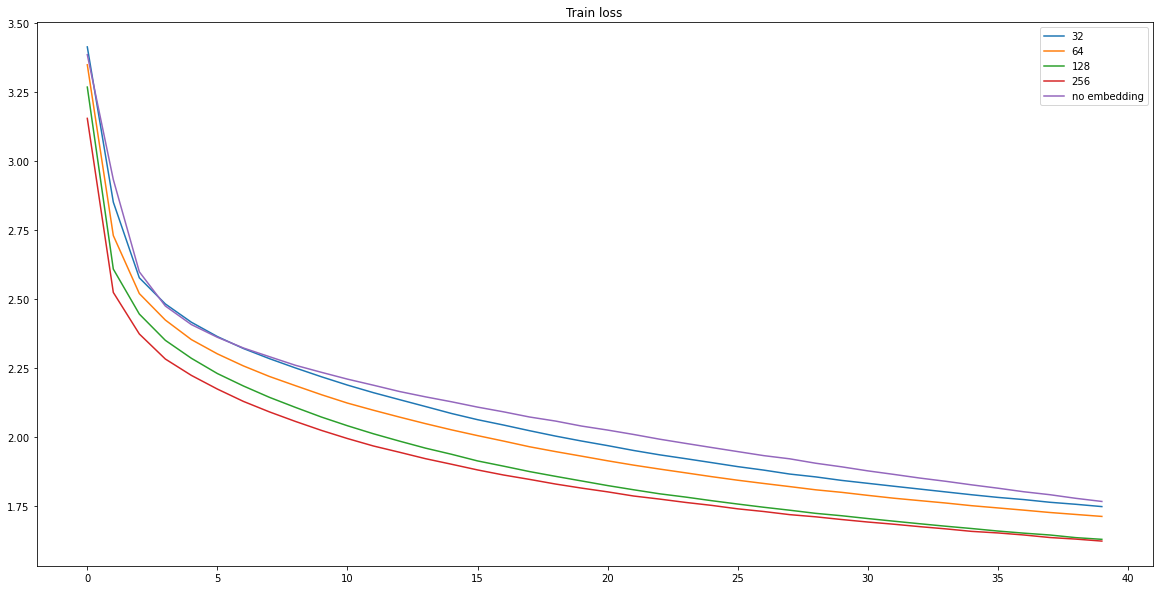

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(histories)):
    h = histories[i]
    embeding_dim = [32,64,128,256,"no embedding"][i]
    plt.plot(h.history["loss"], label=embeding_dim )

plt.legend()
plt.title("Train loss")
plt.show()

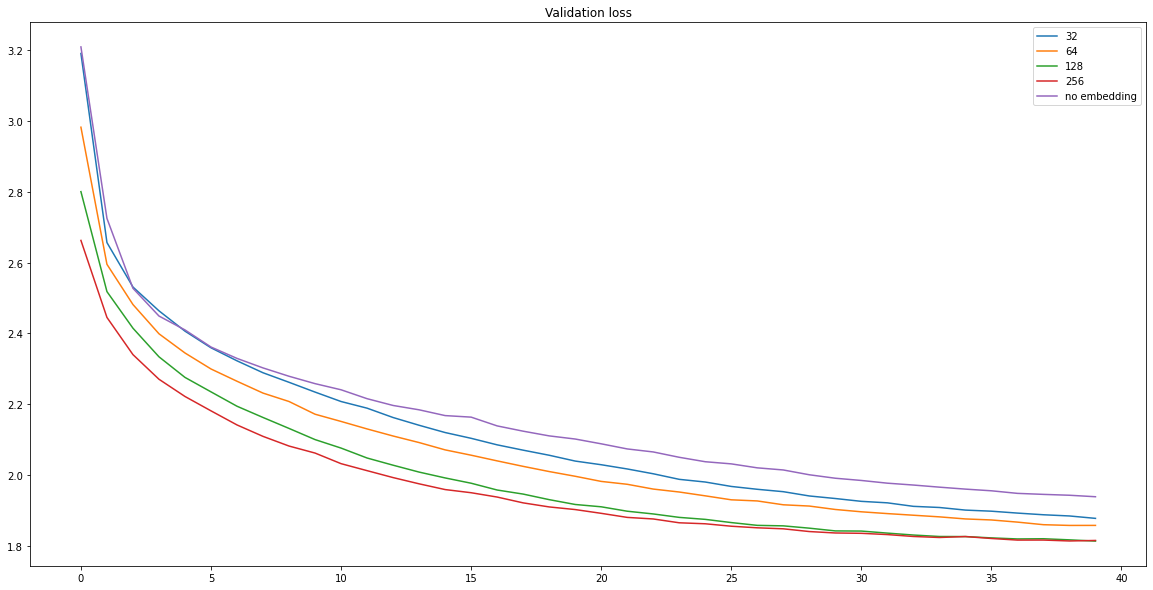

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(histories)):
    h = histories[i]
    embeding_dim = [32,64,128,256,"no embedding"][i]
    plt.plot(h.history["val_loss"], label=embeding_dim )

plt.legend()
plt.title("Validation loss")
plt.show()